The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl


# Convolution

:label:`ch_conv_gpu`


In this section, we will extend :numref:`ch_packed_conv_cpu` to optimize convolution on GPUs.

In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm

target = 'cuda'

## Setup

As usual, we will use MXNet as our baseline, which calls cuDNN to execute the convolution. Like what we have done on CPUs, we benchmark the performance with various numbers of channels, when the input and kernel width/height are fixed to be 64 and 3, respectively. 
The benchmark method `bench_conv_mxnet` has already been defined in :numref:`ch_packed_conv_cpu`. 
The only change that we need to make is to specify to the method that the target device is `GPU`.

[141.16191263962892,
 576.4168098205739,
 1756.5216231285078,
 4736.3599451640575,
 6067.588406748898]

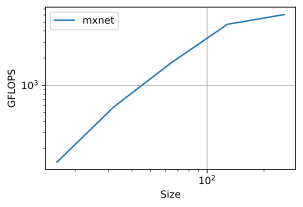

In [2]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]
mx_gflops = d2ltvm.bench_conv_mxnet(sizes, 'gpu')
d2ltvm.plot_gflops(channels, [mx_gflops], ['mxnet'])
mx_gflops

The results above show that on GPUs the performance of convolution increases while the number of channels increases. For showing the gradual performance improvement brought by TVM scheduling, we now fix the channel size to be 64, where MXNet could get to the performance of about 1700 GFLOPS or 1.7 TGLOPS. Please keep this in mind while we are working on the TVM scheduling.

In [3]:
sizes = [(64, 64, 3)]

## Default schedule of CONV

We then describe the computation of convolution in TVM using `conv` method, which is defined in :numref:`ch_packed_conv_cpu`. For a default schedule, we can simply bind two axes of the convolution loop nest into block and thread indexing axes.

In [4]:
def default_sch(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    sch = tvm.create_schedule(Y.op)
    sch[PaddedX].compute_inline()
    _, y, x = sch[Y].op.axis
    sch[Y].bind(y, tvm.thread_axis("blockIdx.x"))
    sch[Y].bind(x, tvm.thread_axis("threadIdx.x"))
    print(tvm.lower(sch, [X, K, Y], simple_mode=True))
    return sch, (X, K, Y)

tvm_gflops = d2ltvm.bench_conv_tvm(default_sch, sizes, target)
tvm_gflops

produce Y {
  for (c, 0, 64) {
    // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 64
    // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 64
    Y[(((c*4096) + (blockIdx.x*64)) + threadIdx.x)] = 0f
    for (ric, 0, 64) {
      for (rkh, 0, 3) {
        for (rkw, 0, 3) {
          Y[(((c*4096) + (blockIdx.x*64)) + threadIdx.x)] = (Y[(((c*4096) + (blockIdx.x*64)) + threadIdx.x)] + (tvm_if_then_else((((((blockIdx.x + rkh) < 1) || (65 <= (blockIdx.x + rkh))) || ((threadIdx.x + rkw) < 1)) || (65 <= (threadIdx.x + rkw))), 0f, X[((((((ric*4096) + (blockIdx.x*64)) + (rkh*64)) + threadIdx.x) + rkw) - 65)])*K[((((c*576) + (ric*9)) + (rkh*3)) + rkw)]))
        }
      }
    }
  }
}



array([128.14201402])

The default scheduling gives us the performance around 100 GFLOPS.

## Tiling

As described in the last section, we can do tiling and bring the data to the shared and local memory of the GPU explicitly to improve the performance. Specifically, we tile three dimensions of the output (channel, height and width) as well as the three reduce dimensions (input channel, kernel height and kernel width). For the output dimensions, we split each of them into three parts for block binding, thread binding and CUDA kernel processing, respectively. The splitting factors are chosen to make sure the data can be fit into the shared and local memory of the GPU.

In our case, we specify the output tile (`YL`) and its corresponding input tiles (`XL` and `KL`) to the local memory, and the tiled input data (`XX`) and kernel (`KK`) to the shared memory. :numref:`fig_conv_thread_block` shows how the tiling works for convolution.

![Blocked tiling for convolution to put small tiles into shared and local memory of GPU.](http://tvm.d2l.ai/_images/conv_thread_block.svg)

:label:`fig_conv_thread_block`


Under our tiling factors below, each thread needs to access $64$(`YL`)$+48$(`XL`)$+24$(`KL`)$=136$ 32-bit floats. And in our setting each block contains $4 \times 2 \times 16 = 128$ threads, making the total occupied local memory registers to be $128 \times 136 = 17,408$, which is easy to be fit into one SM. Similarly, we can reason that `XX` and `KK` are fittable to the shared memory.

In addition, as in the last section, we use cooperative fetching to local the data from GPU host memory to the shared memory in parallel.

In [5]:
tile_c = [4, 8]
tile_h = [2, 2]
tile_w = [16, 4]
tile_rc = [1, 1]
tile_rh = [1, 1]
tile_rw = [1, 3]

# Save to the d2ltvm package.
def split_axis(factors, sch, op, axis):
        """Splitting an axis into factors

        Parameters
        ----------
        factors: array of integers
            The factors that the split applies
        sch: tvm.schedule.Schedule
            The tvm schedule
        op: tvm.tensor.Operation
            The stage to be applied
        axis: tvm.schedule.IterVar
            axis to split

        Returns
        -------
        axes : list of Axis
            The transformed axes.
        """
        ret = []
        for i in range(0, len(factors)):
            ax0, ax1 = sch[op].split(axis, factor=int(np.prod(factors[i:])))
            ret.append(ax0)
            axis = ax1
        return ret + [axis]

def tiling(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    sch = tvm.create_schedule(Y.op)
    sch[PaddedX].compute_inline()
    
    YL = sch.cache_write(Y, 'local')

    # create cache stage
    XX = sch.cache_read(PaddedX, 'shared', [YL])
    KK = sch.cache_read(K, 'shared', [YL])
    XL = sch.cache_read(XX, 'local', [YL])
    KL = sch.cache_read(KK, 'local', [YL])
    
    c, h, w = sch[Y].op.axis
    
    bc, tc, ic = split_axis(tile_c, sch, Y, c)
    bh, th, ih = split_axis(tile_h, sch, Y, h)
    bw, tw, iw = split_axis(tile_w, sch, Y, w)
    
    sch[Y].bind(bc, tvm.thread_axis("blockIdx.z"))
    sch[Y].bind(bh, tvm.thread_axis("blockIdx.y"))
    sch[Y].bind(bw, tvm.thread_axis("blockIdx.x"))
    sch[Y].bind(tc, tvm.thread_axis("threadIdx.z"))
    sch[Y].bind(th, tvm.thread_axis("threadIdx.y"))
    sch[Y].bind(tw, tvm.thread_axis("threadIdx.x"))
    sch[Y].reorder(bc, bh, bw, tc, th, tw, ic, ih, iw)
    
    sch[YL].compute_at(sch[Y], tw)
    
    # tile reduction axes
    c, h, w = sch[YL].op.axis
    rc, rh, rw = sch[YL].op.reduce_axis
    rco, rcm, rci = split_axis(tile_rc, sch, YL, rc)
    rho, rhm, rhi = split_axis(tile_rh, sch, YL, rh)
    rwo, rwm, rwi = split_axis(tile_rw, sch, YL, rw)
    sch[YL].reorder(rco, rho, rwo, rcm, rhm, rwm, rci, rhi, rwi, c, h, w)

    sch[XX].compute_at(sch[YL], rwo)
    sch[KK].compute_at(sch[YL], rwo)
    sch[XL].compute_at(sch[YL], rwm)
    sch[KL].compute_at(sch[YL], rwm)
    
    # cooperative fetching
    for load in [XX, KK]:
        args = sch[load].op.axis
        fused = sch[load].fuse(*args)
        # align thread layout
        tz, fused = sch[load].split(fused, nparts=tile_c[0])
        ty, fused = sch[load].split(fused, nparts=tile_h[0])
        tx, _ = sch[load].split(fused, nparts=tile_w[0])
        sch[load].bind(tz, tvm.thread_axis("threadIdx.z"))
        sch[load].bind(ty, tvm.thread_axis("threadIdx.y"))
        sch[load].bind(tx, tvm.thread_axis("threadIdx.x"))
    
    return sch, (X, K, Y)

tvm_gflops = d2ltvm.bench_conv_tvm(tiling, sizes, target)
tvm_gflops

array([1862.67297381])

The performance increases over one order of magnitude which is already on par with our baseline. We can still improve it by solving some bank conflict issue when accessing the data.

## Optimizing the data access on GPUs

### Bank Conflict

In the scheduling above, all threads will read `XX` and `KK` simultaneously, which may harm the performance. To understand it, we need to dive a little bit into the shared memory architecture and how threads are executed. 

Remember that we created 128 threads for a thread block. Due to resource limits, we cannot execute all of them at the same time. Instead, each time we select a group of threads and run time simultaneously, and then switch to another group quickly. Such a group is called a *warp*, which contains 32 threads, and each having a consecutive thread index. 

Each thread in a warp can access data in the shared memory simultaneously. So the shared memory is designed to support parallel load and store. The basic unit of the shared memory is *word*. Each word has 4 bytes, which can hold a single 32-bit floating number. Words are grouped into 32 banks. The $j$-th word is in the $i$-th bank if `j % 32 == i`. 

Each bank can only handle a single request at a time, while these 32 banks are processed in parallel. So the shared memory performs fastest when each bank gets one request from a single thread in the warp, therefore we can access 32 words at the same time. However, if there are two threads requesting data from the same bank, we need to serialize these two requests. This is called a *bank conflict*. A special case is that if all (or some) threads of a warp request the same word in a bank, then the word will only read once and broadcast (multicast) to each thread, so there is no bank conflict. :numref:`fig_bank_conflict` illustrated these three cases.

![Accessing shared memory](http://tvm.d2l.ai/_images/bank_conflict.svg)

:label:`fig_bank_conflict`


### Data Access Pattern
Now let's analyze the read pattern of `XX` and `KK`. Note from :numref:`fig_conv_thread_block` that a thread reads a row segment of `XX` with a length of 4 consecutive numbers, which spread in 4 adjacent banks which causes severe bank conflict. The same thing applies to the reading of `KK`. 

One way to mitigate this is to let the thread read in columns instead of rows, so each reading would have a stride, making the numbers to be read from one thread more spread among banks. :numref:`fig_conv_row_column` shows the difference of the reading patterns from shared memory to local memory.

![Different reading patterns from shared memory to local memory](http://tvm.d2l.ai/_images/conv_row_column.svg)

:label:`fig_conv_row_column`


### Virtual Threads 

In addition, TVM provides another mechanism, called *virtual thread*, to further increase the data access stride to mitigate bank conflict. Let's revisit the thread structure we defined above. Each block has 16 threads in the `x` dimension, each thread processes 4 elements. It conceptually gets data in the pattern depicted in the left of :numref:`fig_conv_virtual_thread`.

In order to let threads to process data in a spread manner, we can use virtual threads to obtain strided data chunks. For example, we can first split the data into 2 parts to bind to 2 virtual threads. Then we further split the each part into 16 pieces to bind to 16 CUDA threads. In practice, the $i$-th CUDA thread in all virtual threads will be merged into a single one, so we will only get 16 CUDA threads instead of $16 \times 2$ threads. In this case, each thread processes two spread data pieces as depicted in the right of :numref:`fig_conv_virtual_thread`.

![Virtual thread binding](http://tvm.d2l.ai/_images/conv_virtual_thread.svg)

:label:`fig_conv_virtual_thread`

In [6]:
tile_c = [1, 4, 8]
tile_h = [1, 2, 2]
tile_w = [2, 16, 2] # making 2 virtual thread along the ow dimension
tile_rc = [1, 1]
tile_rh = [1, 3] # making the data access in columns
tile_rw = [1, 1]

def vthread(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    sch = tvm.create_schedule(Y.op)
    sch[PaddedX].compute_inline()
    
    YL = sch.cache_write(Y, 'local')

    # create cache stage
    XX = sch.cache_read(PaddedX, 'shared', [YL])
    KK = sch.cache_read(K, 'shared', [YL])
    XL = sch.cache_read(XX, 'local', [YL])
    KL = sch.cache_read(KK, 'local', [YL])
    
    c, h, w = sch[Y].op.axis
    
    bc, vc, tc, ic = split_axis(tile_c, sch, Y, c)
    bh, vh, th, ih = split_axis(tile_h, sch, Y, h)
    bw, vw, tw, iw = split_axis(tile_w, sch, Y, w)
    
    sch[Y].bind(bc, tvm.thread_axis("blockIdx.z"))
    sch[Y].bind(bh, tvm.thread_axis("blockIdx.y"))
    sch[Y].bind(bw, tvm.thread_axis("blockIdx.x"))
    sch[Y].bind(vc, tvm.thread_axis("vthread"))
    sch[Y].bind(vh, tvm.thread_axis("vthread"))
    sch[Y].bind(vw, tvm.thread_axis("vthread"))
    sch[Y].bind(tc, tvm.thread_axis("threadIdx.z"))
    sch[Y].bind(th, tvm.thread_axis("threadIdx.y"))
    sch[Y].bind(tw, tvm.thread_axis("threadIdx.x"))
    sch[Y].reorder(bc, bh, bw, vc, vh, vw, tc, th, tw, ic, ih, iw)
    
    sch[YL].compute_at(sch[Y], tw)
    
    # tile reduction axes
    c, h, w = sch[YL].op.axis
    rc, rh, rw = sch[YL].op.reduce_axis
    rco, rcm, rci = split_axis(tile_rc, sch, YL, rc)
    rho, rhm, rhi = split_axis(tile_rh, sch, YL, rh)
    rwo, rwm, rwi = split_axis(tile_rw, sch, YL, rw)
    sch[YL].reorder(rco, rho, rwo, rcm, rhm, rwm, rci, rhi, rwi, c, h, w)

    sch[XX].compute_at(sch[YL], rwo)
    sch[KK].compute_at(sch[YL], rwo)
    sch[XL].compute_at(sch[YL], rwm)
    sch[KL].compute_at(sch[YL], rwm)
    
    # cooperative fetching
    for load in [XX, KK]:
        args = sch[load].op.axis
        fused = sch[load].fuse(*args)
        # align thread layout
        tz, fused = sch[load].split(fused, nparts=tile_c[1])
        ty, fused = sch[load].split(fused, nparts=tile_h[1])
        tx, _ = sch[load].split(fused, nparts=tile_w[1])
        sch[load].bind(tz, tvm.thread_axis("threadIdx.z"))
        sch[load].bind(ty, tvm.thread_axis("threadIdx.y"))
        sch[load].bind(tx, tvm.thread_axis("threadIdx.x"))
    
    return sch, (X, K, Y)

tvm_gflops = d2ltvm.bench_conv_tvm(vthread, sizes, target)
tvm_gflops

array([2697.10080218])

After carefully optimizing the data access, the performance we get outperforms our baseline at `channel=64`.

Now let's vary the number of channels to test out the convolution performance obtained by TVM more comprehensively. And then we can plot the chart to compare MXNet and TVM.

array([ 708.34332193, 1831.35175204, 2689.02006478, 3387.8795943 ,
       3701.04538769])

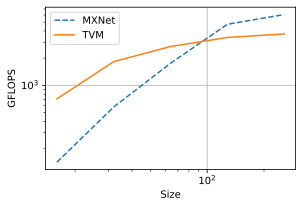

In [7]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]
target = 'cuda'
tvm_gflops = d2ltvm.bench_conv_tvm(vthread, sizes, target)
d2ltvm.plot_gflops(channels, [mx_gflops, tvm_gflops], legend=['MXNet', 'TVM'])
tvm_gflops

From the figure we see that TVM outperforms MXNet in smaller channel sizes but MXNet becomes better as the number of channels increases. This is mostly because cuDNN used by MXNet has manually optimized implementation for different data shapes, but here we use only one scheduling strategy for convolution kernels in different sizes.

You may wonder how we can choose different schedules for convolutions of different data sizes, and even better, if we can automate the choice of schedules given a specific set of data shapes for convolution. We will talk about these techniques later.

In addition, there are ways that one can do to further increase the performance. For example, we can try to avoid all bank conflict by making the data reading stride always a multiple of 32. However, these tricks may be ad hoc and require intensive programming efforts. Our goal is to come up with some more high-level and generic scheduling scheme to achieve the reasonable performance.

## Summary
- We leverage the memory hierarchy of GPU to tile the data for better convolution performance.
- We carefully manipulate the data access pattern to mitigate bank conflict which harms the performance.

## Exercise
- Try our different factors to split the axes and observe the performance difference.
- Vary the size of input data and observe the performance difference.